# Energy level diagrams for state preparation - lens to interaction region
## Intro
This notebook calculates energy levels of TlF for the fields found when traversing along the beamline from the electrostatic lens to the interaction region via a state preparation region.

I'm simulating the full TlF level structure, so we have $I_1 = \frac{1}{2}$ and $I_2 = \frac{1}{2}$.

First set up the code to calculate the energies:

In [1]:
#Import packages
import sys
sys.path.append('../../non-adiabatic-transitions/molecular-state-classes-and-functions/')
import numpy as np
import sympy
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from classes import UncoupledBasisState, CoupledBasisState, State
from functions import matrix_to_states, follow_energy
%matplotlib notebook
%load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
#Import Hamiltonian
with open("hamiltonians_symbolic.py", 'rb') as f:
    hamiltonians = pickle.load(f)
with open("Hff_alt_mat.py", 'rb') as f:
    Hff_alt_mat_m = pickle.load(f)["Hff_alt_mat"]

    
Jmax = sympy.Integer(6) # max J value in Hamiltonian
I_Tl = 1/2             # I1 in Ramsey's notation/
I_F  = 1/2             # I2 in Ramsey's notation

def ni_range(x0, x1, dx=1):
    # sanity check arguments
    if dx==0:
        raise ValueError("invalid parameters: dx==0")
    if x0>x1 and dx>=0:
        raise ValueError("invalid parameters: x0>x1 and dx>=0")
    if x0<x1 and dx<=0:
        raise ValueError("invalid parameters: x0<x1 and dx<=0")
        
    # generate range list
    range_list = []
    x = x0
    while x < x1:
        range_list.append(sympy.Number(x))
        x += dx
    return range_list

#Make list of states so that can find states in the Hamiltonian
QN = [UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J  in ni_range(0, Jmax+1)
      for mJ in ni_range(-J,J+1)
      for m1 in ni_range(-I_Tl,I_Tl+1)
      for m2 in ni_range(-I_F,I_F+1)
     ]

Convert the `sympy` `Matrix` into a `numpy` array:

In [ ]:
%%time
variables = [
    sympy.symbols('Brot'),
    *sympy.symbols('c1 c2 c3 c4'),
    sympy.symbols('D_TlF'),
    *sympy.symbols('mu_J mu_Tl mu_F')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Insert numerical constants into Hamiltonian (all in units of Hz):

In [ ]:
%%time
Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0
D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]
mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

H = {
    H_name : H_fn(
        Brot,
        c1, c2, c3, c4,
        D_TlF,
        mu_J, mu_Tl, mu_F
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}

### Find the energies

Above, we have evaluated the matrix elements for the zero-field Hamiltonian $H_\text{ff}$, as well as the $\vec E=1=\vec B$ cases. For general fields $\vec E,\vec B$, the Hamiltonian is

$$
H=H_\text{ff}
+
\begin{pmatrix}
E_x\\E_y\\E_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{S}_x\\H^\text{S}_y\\H^\text{S}_z
\end{pmatrix}
+
\begin{pmatrix}
B_x\\B_y\\B_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{Z}_x\\H^\text{Z}_y\\H^\text{Z}_z
\end{pmatrix}.
$$

When looking at the Zeeman/Stark effects on the hyperfine structure, the rotational structure is not of interest, so I subtract it for clarity in the following `spectrum()` function. It evaluates the above Hamiltonian for each point on the array of fields, and returns a list of energy levels, sorted by size:

In [ ]:
def spectrum(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
    energies_arr = []
    energies_rot_arr = []
    states_arr = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = H["Hff"] + \
            Ex*H["HSx"]  + Ey*H["HSy"] + Ez*H["HSz"] + \
            Bx*H["HZx"]  + By*H["HZy"] + Bz*H["HZz"]
        D, V = np.linalg.eigh(HamE)
        idx = D.argsort() 
        D = D[idx]
        V = V[:,idx]
        
        # Subtract away rotational energy for easier viewing of substructure
        hfs_mat = []
        for i,state in enumerate(QN):
            J = state.J
            hfs_mat.append(D[i] - J*(J +1)*Brot)
        hfs_kHz = np.array(hfs_mat)/1000

        energies_arr.append(hfs_kHz)
        energies_rot_arr.append(D)
        states_arr.append(V)
    return np.array(energies_arr), np.array(energies_rot_arr), np.array(states_arr)

## Field free

In [ ]:
#Set values for electric and magnetic field
Ez = 30e3*np.linspace(0,1,1000)
Bz = 0*np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

#Calculate energies
energies, energies_rot, e_states = spectrum(Ex,Ey,Ez,Bx,By,Bz)

Text(0,0.5,'Energy / GHz')

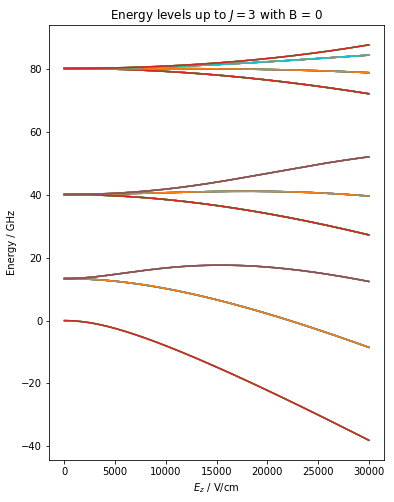

In [7]:
#Plot energies
fig, ax = plt.subplots(figsize = (6,8))

for i in range(0,64):
    ax.plot(Ez, energies_rot.T[i]/1e9)

ax.set_title("Energy levels up to $J = 3$ with B = 0")
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / GHz")

In [11]:
energies[0,0]

-3.32500000000000

## Hinds experiment state selection
This section calculates the energies for the field used in the Hinds experiment (1991). 

In [8]:
#Set values for electric and magnetic field
Ez = 300*np.linspace(0,1,300)
Bz = 27*np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

#Calculate energies
energies, energies_rot, e_states = spectrum(Ex,Ey,Ez,Bx,By,Bz)

Text(225,6742.93,'Buffer field')

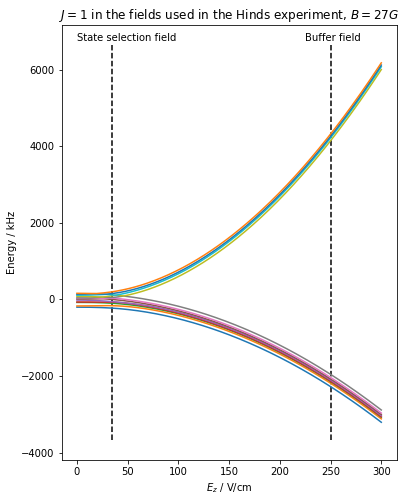

In [9]:
#Plot energies
fig, ax = plt.subplots(figsize = (6,8))

for i in range(4,16):
    ax.plot(Ez, energies.T[i])

ax.set_title("$J=1$ in the fields used in the Hinds experiment, $B = 27 G$")
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")

#Plot a vertical line at the E-field used in the state selection region in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(35,ylim[0],ylim[1],linestyle = '--')
ax.text(0, ylim[1]+100,'State selection field')

#Plot a vertical line at the E-field used in the buffer region in the Hinds experiment
ax.vlines(250,ylim[0],ylim[1],linestyle = '--')
ax.text(225, ylim[1]+100,'Buffer field')

Also plot a zoomed in version for what is happening at smaller fields:


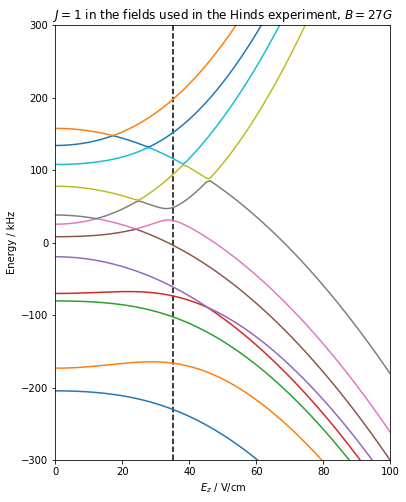

In [10]:
#Plot energies
fig, ax = plt.subplots(figsize = (6,8))
ax.set_xlim((0,100))
ax.set_ylim((-300,300))
for i in range(4,16):
    ax.plot(Ez, energies.T[i])

ax.set_title("$J=1$ in the fields used in the Hinds experiment, $B = 27 G$")
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")


#Plot a vertical line at the E-field used in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(35,ylim[0],ylim[1],linestyle = '--')

No handles with labels found to put in legend.


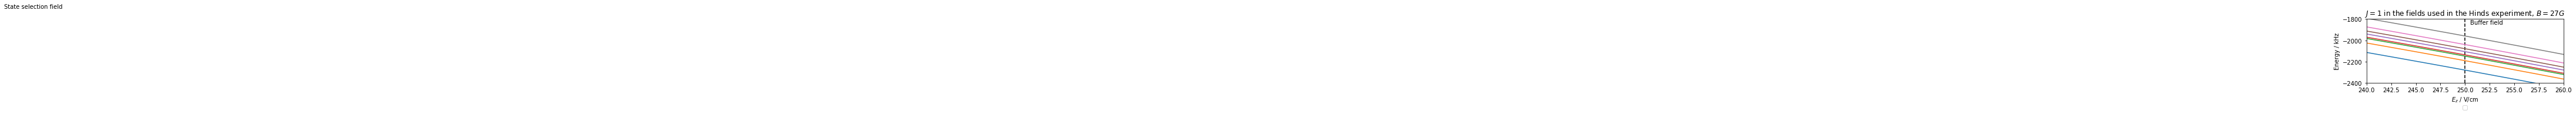

In [11]:
#Zoomed in plot at 250 V/cm
#Plot energies
fig, ax = plt.subplots()

ax.set_title("$J=1$ in the fields used in the Hinds experiment, $B = 27 G$")
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")
xlim = (240,260)
ax.set_xlim(xlim)
ylim = (-2400,-1800)
ax.set_ylim(ylim)


for i in range(4,12):
    ax.plot(Ez, energies.T[i])
    offset = 2*i-10
    
    #ax.text(245+offset, energies.T[i,245+offset],label)

    
    
#Plot a vertical line at the E-field used in the state selection region in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(35,ylim[0],ylim[1],linestyle = '--')
ax.text(0, ylim[1]+100,'State selection field')

#Plot a vertical line at the E-field used in the buffer region in the Hinds experiment
ax.vlines(250,ylim[0],ylim[1],linestyle = '--')
ax.text(250.5, ylim[1]-50,'Buffer field')

#Plot legend
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0+box.height*0.5, box.width, box.height*.5])

# Put a legend to the right of the current axis
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)


## State selection region using 100 V/cm electric field
Investigating using a 250 V/cm electric field and 

In [12]:
B0 = 17.9
#Set values for electric and magnetic field
Ez = 150*np.linspace(0,1,300)
Bz = B0*np.ones(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

#Calculate energies
energies, energies_rot, e_states = spectrum(Ex,Ey,Ez,Bx,By,Bz)

In [13]:
eigenstates_E = matrix_to_states(e_states[200,:,:],QN)

100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:02<00:00, 69.99it/s]


Text(0,0.5,'Energy / kHz')

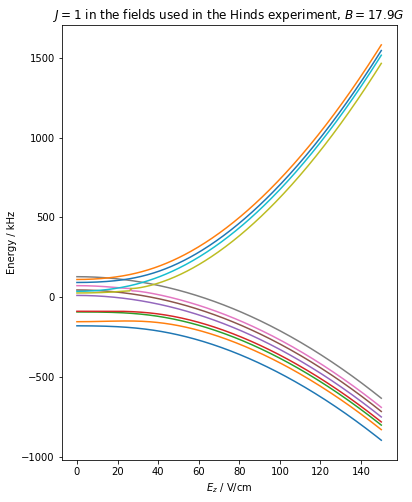

In [14]:
#Plot energies
fig, ax = plt.subplots(figsize = (6,8))

for i in range(4,16):
    state = eigenstates_E[i]
    label = state.print_largest_components()
    energy = follow_energy(energies,e_states,state.state_vector(QN))
    ax.plot(Ez, energy,label = label)
    offset = 2*i-10

ax.set_title("$J=1$ in the fields used in the Hinds experiment, $B = {:.1f} G$".format(B0))
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")


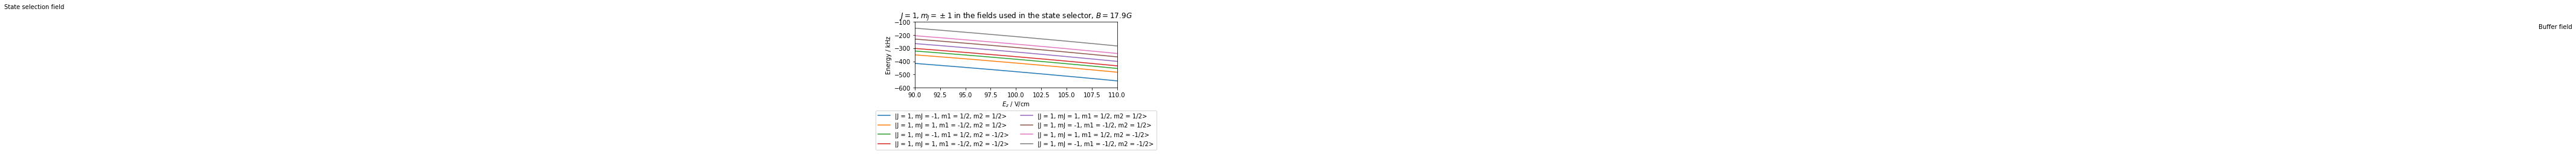

In [15]:
#Zoomed in plot at 250 V/cm
#Plot energies
fig, ax = plt.subplots()

ax.set_title("$J=1, m_J = \pm 1$ in the fields used in the state selector, $B = {:.1f} G$".format(B0))
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")
xlim = (90,110)
ax.set_xlim(xlim)
ylim = (-600,-100)
ax.set_ylim(ylim)


for i in range(4,12):
    state = eigenstates_E[i]
    label = state.print_largest_components()
    energy = follow_energy(energies,e_states,state.state_vector(QN))
    ax.plot(Ez, energy,label = label)
    offset = 2*i-10
    
    #ax.text(245+offset, energies.T[i,245+offset],label)

    
    
#Plot a vertical line at the E-field used in the state selection region in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(35,ylim[0],ylim[1],linestyle = '--')
ax.text(0, ylim[1]+100,'State selection field')

#Plot a vertical line at the E-field used in the buffer region in the Hinds experiment
ax.vlines(250,ylim[0],ylim[1],linestyle = '--')
ax.text(250.5, ylim[1]-50,'Buffer field')

#Plot legend
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0+box.height*0.5, box.width, box.height*.5])

# Put a legend to the right of the current axis
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)


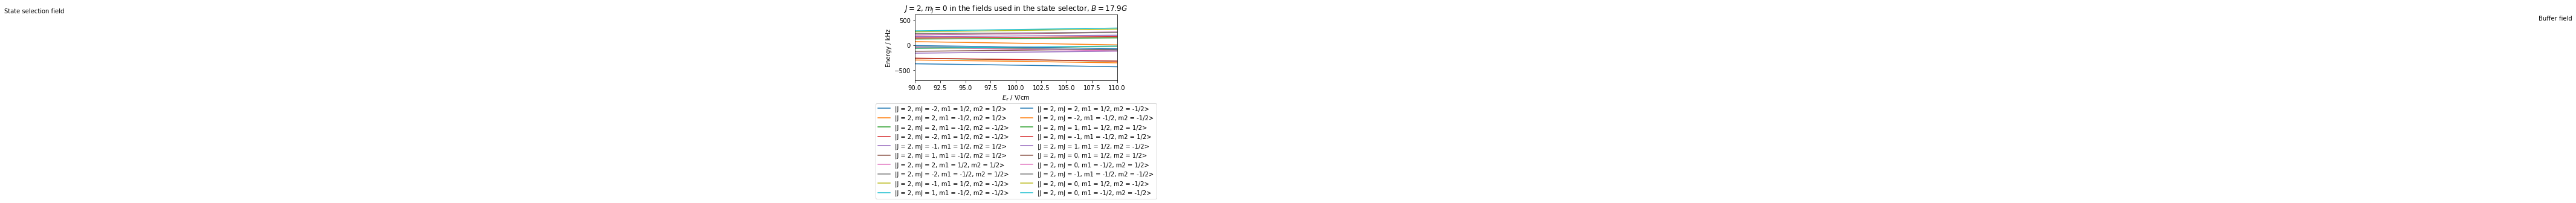

In [16]:
#Zoomed in plot at 250 V/cm
#Plot energies
fig, ax = plt.subplots()

ax.set_title("$J=2, m_J = 0$ in the fields used in the state selector, $B = {:.1f} G$".format(B0))
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / kHz")
xlim = (90,110)
ax.set_xlim(xlim)
ylim = (150,400)
#ax.set_ylim(ylim)


for i in range(16,36):
    state = eigenstates_E[i]
    label = state.print_largest_components()
    energy = follow_energy(energies,e_states,state.state_vector(QN))
    ax.plot(Ez, energy,label = label)
    offset = 2*i-10
    
    #ax.text(245+offset, energies.T[i,245+offset],label)

    
    
#Plot a vertical line at the E-field used in the state selection region in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(35,ylim[0],ylim[1],linestyle = '--')
ax.text(0, ylim[1]+100,'State selection field')

#Plot a vertical line at the E-field used in the buffer region in the Hinds experiment
ax.vlines(250,ylim[0],ylim[1],linestyle = '--')
ax.text(250.5, ylim[1]-50,'Buffer field')

#Plot legend
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0+box.height*0.5, box.width, box.height*.5])

# Put a legend to the right of the current axis
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)

Next determine the energy difference between the lens states and the EDM measurement states

In [17]:
#Find average energy of the lens states, i.e. J=2, mJ = 0
#Define the nominal quantum numbers of the states
J = 2
mJ = 0
I1 = 1/2
I2 = 1/2
lens_states = []

for m1 in np.arange(-I1,I1+1):
    for m2 in np.arange(-I2,I2+1):
        lens_states.append(UncoupledBasisState(J,mJ,I1,m1,I2,m2).make_state())
        
#Find the index of each of the lens states in the list of eigenstates
lens_state_indices = []

for lens_state in lens_states:
    overlaps = np.zeros(len(eigenstates_E))
    for i,eigenstate in enumerate(eigenstates_E):
        overlaps[i] = np.absolute(eigenstate@lens_state)
    lens_state_indices.append(np.argmax(overlaps))

lens_state_energies = np.zeros((len(energies[:,0]),len(lens_state_indices)))
    
#fig,ax = plt.subplots()
for n, i in enumerate(lens_state_indices):
    state = eigenstates_E[i]
    label = state.print_largest_components()
    lens_state_energies[:,n] = follow_energy(energies_rot,e_states,state.state_vector(QN))
    #ax.plot(Ez, energy,label = label)
    
#Find the average energy of the lens states
lens_states_average_energy = np.mean(lens_state_energies, axis=1)
# fig,ax = plt.subplots()
# ax.plot(Ez,lens_states_average_energy)

In [18]:
#Next find the energies of the states e = |J = 1, mJ = -1, m1 =-1/2, m2 = -1/2>  and h =  |J = 1, mJ = +1, m1 = +1/2, m2 = +1/2> 
#Define the states first
state_e = UncoupledBasisState(1,-1,1/2,-1/2,1/2,-1/2).make_state()
state_h = UncoupledBasisState(1,1,1/2,1/2,1/2,1/2).make_state()

#Find indices for the two states
state_e_index = np.argmax(np.absolute(np.array([eigenstate@state_e for eigenstate in eigenstates_E])))
state_h_index = np.argmax(np.absolute(np.array([eigenstate@state_h for eigenstate in eigenstates_E])))

#Find energies
state_e_energy = follow_energy(energies_rot,e_states,state_e.state_vector(QN))
state_h_energy = follow_energy(energies_rot,e_states,state_h.state_vector(QN))

#Plot energies
# fig,ax = plt.subplots()
# ax.plot(Ez,state_e_energy)
# ax.plot(Ez,state_h_energy)

In [19]:
eigenstates_E[state_e_index].remove_small_components(.05).print_state()

+1.0000 x |J = 1, mJ = -1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>


In [20]:
for index in lens_state_indices:
    print(str(index) +'=')
    eigenstates_E[index].remove_small_components(.05).print_state()

35=
+0.1096 x |J = 2, mJ = -1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
+0.5004 x |J = 2, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
+0.8581 x |J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>
32=
+0.4446 x |J = 2, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
+0.8544 x |J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
-0.2450 x |J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
-0.1106 x |J = 2, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>
34=
-0.1506 x |J = 2, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
-0.2194 x |J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
-0.7878 x |J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
-0.5554 x |J = 2, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>
31=
-0.7381 x |J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
-0.5437 x |J = 2, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
-0.3806 x |J = 2, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
-0.1212 x |J = 2, mJ = 2, I1 = 1/2, m1 = -

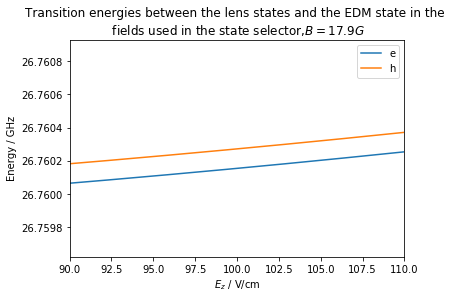

In [21]:
#Calculate energy difference between lens state and the EDM measurement states
transition_energy_e = lens_states_average_energy - state_e_energy
transition_energy_h = lens_states_average_energy - state_h_energy

fig, ax = plt.subplots()
ax.set_title("Transition energies between the lens states and the EDM state in the \n fields used in the state selector,$B = {:.1f} G$".format(B0))
ax.set_xlabel("$E_z$ / V/cm")
ax.set_ylabel("Energy / GHz")
xlim = (90,110)
ax.set_xlim(xlim)
ylim = (150,400)
#ax.set_ylim(ylim)

ax.plot(Ez, transition_energy_e/1e9, label = 'e')
ax.plot(Ez, transition_energy_h/1e9, label = 'h')
ax.legend()

### Optimal magnetic field
Check effect of magnetic field on the separation of the $J = 1, m_J = \pm 1$ states

In [22]:
#Set values for electric and magnetic field
Bz = 50*np.linspace(0,1,300)
Ez = 100*np.ones(Bz.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

#Calculate energies
energies, energies_rot, e_states = spectrum(Ex,Ey,Ez,Bx,By,Bz)

In [23]:
eigenstates_B = matrix_to_states(e_states[162,:,:],QN)

100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [00:02<00:00, 74.48it/s]


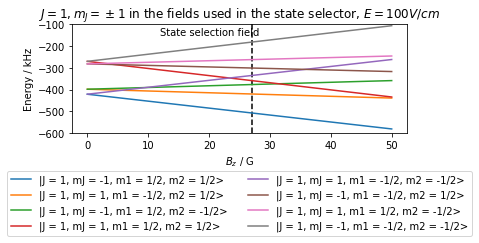

In [24]:
#Plot energies
fig, ax = plt.subplots()

ax.set_title("$J=1, m_J = \pm 1$ in the fields used in the state selector, $E = 100 V / cm$")
ax.set_xlabel("$B_z$ / G")
ax.set_ylabel("Energy / kHz")
xlim = (0,50)
#ax.set_xlim(xlim)
ylim = (-600,-100)
ax.set_ylim(ylim)


for i in range(4,12):
    state = eigenstates_B[i]
    label = state.print_largest_components()
    energy = follow_energy(energies,e_states,state.state_vector(QN))
    ax.plot(Bz, energy,label = label)
    offset = 2*i-10
    
    #ax.text(245+offset, energies.T[i,245+offset],label)

    
    
#Plot a vertical line at the E-field used in the state selection region in the Hinds experiment
ylim = ax.get_ylim()
ax.vlines(27,ylim[0],ylim[1],linestyle = '--')
ax.text(27-15, ylim[1]-50,'State selection field')

#Plot legend
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0+box.height*0.5, box.width, box.height*.5])

# Put a legend to the right of the current axis
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=2)


Check the energy spacing between $|J=1, m_J = 1, m_1 =\frac{1}{2}, m_2 = \frac{1}{2} >$ and the closest state for varying magentic field strength

-1.0000 x |J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
-0.0036 x |J = 2, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>


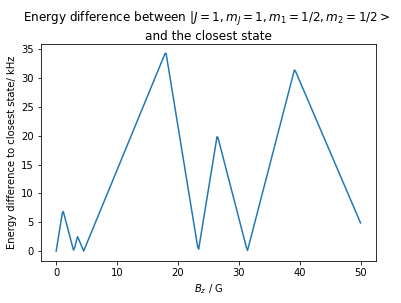

In [25]:
#Find the energy of the state 'h' in Ramsey labeling
state_h = eigenstates_B[7]
state_h.remove_small_components().print_state()
state_h_energy = follow_energy(energies_rot,e_states,state_h.state_vector(QN))

#Make mask for selecting all energies except energy of 'h' itself
mask = np.ones(energies_rot[0,:].shape[0], dtype=bool)
mask[7] = 0

#Calculate energy differences between 'h' and all the other states
energy_differences = np.absolute(np.array([energy - energies_rot[i,:] for i, energy in enumerate(state_h_energy)]))

#Find the minimum energy difference for each value of B-field
min_energy_difference = np.partition(energy_differences,2, axis = 1)[:,1]


#Plot the minimum energy difference vs B-field
fig, ax = plt.subplots()
ax.set_xlabel("$B_z$ / G")
ax.set_ylabel("Energy difference to closest state/ kHz")
ax.set_title('Energy difference between $|J=1, m_J = 1, m_1 =1/2, m_2 = 1/2 >$ \nand the closest state')
ax.plot(Bz,min_energy_difference/1e3)

In [26]:
#What field gives maxiumum energy separation
Bz[np.argmax(min_energy_difference)]

17.892976588628763